# Reproduction of Carnegie Research Activity Index Method

## 2021 Rankings Revised

Based on https://carnegieclassifications.iu.edu/pdf/CCIHE2021_Research_Activity_Index_Method.pdf


scikit-learn PCA loadings example found here: https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html


In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from  sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
scaler = StandardScaler()

DATA =  '..\..\Desktop\Carnegie'
# import sklearn

### Import data only using columns required for ranking

The data for the 277 institutions that were included in the analysis within the public file
(http://carnegieclassifications.iu.edu/downloads/CCIHE2018-PublicDataFile.xlsx) specifically, the
columns labeled: S&ER&D, NONS&ER&D, PDNFRSTAFF, FACNUM (used for per capita index calculation),
HUM_RSD, SOCSC_RSD, STEM_RSD, OTHER_RSD. We added one additional column to indicate which rows to include. 

In [2]:

columns = ['name', 'include','serd','nonserd','pdnfrstaff','facnum','socsc_rsd','hum_rsd','stem_rsd','oth_rsd']
data2021 = pd.read_excel(DATA+'\\CCIHE2021-PublicData_02022022.xlsx', sheet_name='Data',engine='openpyxl', usecols=columns, index_col='name')


### Select only the 277 institutions with valid data


In [3]:
data2021 = data2021[data2021['include']==1]
data2021.fillna(value=0, inplace=True)
data2021.shape

(277, 9)

#### Check for UNT

In [5]:
data2021.loc['University of North Texas']

include           1.0
serd          57764.0
nonserd       26475.0
pdnfrstaff       66.0
facnum          788.0
socsc_rsd        29.0
hum_rsd          75.0
stem_rsd         78.0
oth_rsd         130.0
Name: University of North Texas, dtype: float64

**Step 1**: Calculate the three per capita measures by dividing each of the three research measures
(S&ER&D, NONS&ER&D, PDNFRSTAFF) by the number of full-time ladder-rank faculty
(FACNUM).

In [6]:
per_cap_serd = data2021['serd']/data2021['facnum']
per_cap_non_serd = data2021['nonserd']/data2021['facnum']
per_cap_staff = data2021['pdnfrstaff']/data2021['facnum']

**Step 2**: Convert all ten measures (the 7 raw measures and 3 per capita ones) to ranks from low = 1 to
high = 261 (i.e., ascending order). 

In [7]:
per_cap_serd_rank     = per_cap_serd.rank()
per_cap_non_serd_rank = per_cap_non_serd.rank()
per_cap_staff_rank    = per_cap_staff.rank()

serd_rank      = data2021['serd'].rank()
non_serd_rank  = data2021['nonserd'].rank()
staff_rank     = data2021['pdnfrstaff'].rank()
hum_rsd_rank   = data2021['hum_rsd'].rank()
sosc_rsd_rank  = data2021['socsc_rsd'].rank()
stem_rsd_rank  = data2021['stem_rsd'].rank()
other_rsd_rank = data2021['oth_rsd'].rank()

**Note**: Carnegie uses the “RANK.AVG” function within Excel, where ties all receive the average value of the group followed by the next available number. For example, the seven numbers 10, 8, 8, 4, 4, 4, 2 would be ranked 7, 5.5, 5.5, 3, 3, 3, 1.

We verify pandas rank() method returns the same values.

In [8]:
test_rank = pd.Series([10, 8, 8, 4, 4, 4, 2]).rank()
print(test_rank)
assert(list(test_rank.values) == [7, 5.5, 5.5, 3, 3, 3, 1])

0    7.0
1    5.5
2    5.5
3    3.0
4    3.0
5    3.0
6    1.0
dtype: float64


**Step 3a**: Calculate the the PCA loadings for the per-capita and aggregated measures. 

In [9]:
RankDF_cap  = pd.DataFrame({
        'per_cap_serd'     : per_cap_serd_rank, 
        'per_cap_non_serd' : per_cap_non_serd_rank,
        'per_cap_staff'    : per_cap_staff_rank})
RankDF_agg = pd.DataFrame({
        'serd'             : serd_rank,
        'non_serd'         : non_serd_rank,
        'staff'            : staff_rank,
        'hum_rsd'          : hum_rsd_rank,
        'sosc_rsd'         : sosc_rsd_rank,
        'stem_rsd'         : stem_rsd_rank,
        'other_rsd'        : other_rsd_rank})

In [10]:

print('Per Capita PCA Loading')
scaler = StandardScaler()
X = scaler.fit_transform(RankDF_cap)
pca = PCA( n_components=0.7, svd_solver='full')
pca.fit(X)

loadings_cap = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_matrix_cap = pd.DataFrame(loadings_cap, columns=['PC1'], index=RankDF_cap.columns)

display(loadings_matrix_cap)


Per Capita PCA Loading


,PC1
per_cap_serd,0.932738
per_cap_non_serd,0.644228
per_cap_staff,0.940668


In [11]:
print('Aggregate PCA Loading')

X = scaler.fit_transform(RankDF_agg)
scaler = StandardScaler()
pca = PCA(n_components=0.7, svd_solver = 'full')
pca.fit(X)

loadings_agg = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_matrix_agg = pd.DataFrame(loadings_agg, columns=['PC1'], index=RankDF_agg.columns)

display(loadings_matrix_agg)

Aggregate PCA Loading


,PC1
serd,0.906909
non_serd,0.810214
staff,0.914327
hum_rsd,0.847525
sosc_rsd,0.881997
stem_rsd,0.921395
other_rsd,0.597858


**Step 3b**: For each institution, calculate the aggregate index score and the per capita index score by
multiplying the appropriate ranks (first seven measures for aggregate; 3 per capita measures for
the per capita index) by the “PCA Coefficients” that are provided in the Research Activity Index
file (http://carnegieclassifications.iu.edu/downloads/CCIHE2018-Research_Activity_Index.xlsx)
and summing the weighted ranks for each index (resulting in two indexes). Make sure to copy
the values from the spreadsheet rather than retyping what appears in the cells (full precision).

For Ref the loadings provided by Carnegie:
**PCA loadings based on rank-order data**
	
| Aggregate analysis (first principal component explained 71% of the total variance)  |                   |
|-------------------------------------------------------------------------------------|-------------------|
| Doctorates:   STEM                                                                  | 0.919730180239332 |
| S&E   R&D Expenditures                                                              | 0.905270273247673 |
| Research   Staff                                                                    | 0.912674670686086 |
| Doctorates:   Social Sciences                                                       | 0.880403381303547 |
| Doctorates:   Humanities                                                            | 0.845993629288804 |
| Non-S&E   R&D Expenditures                                                          | 0.808750193756221 |
| Doctorates:   Other Fields                                                          | 0.596778270541235 |

<br>

| Per-capita analysis (first principal component explained 71% of the total variance) |                   |
| ------------------------------------------------------------------------------------|-------------------|
| Per-capita   S&E R&D Expenditures                                                   | 0.931052822583503          |
| Per-capita   Research Staff                                                         | 0.938968171362943          |
| Per-capita   Non-S&E R&D Expenditures                                               | 0.643064073800641          |


In [12]:
agg_index = pd.Series(data= [0]*len(RankDF_agg), name='agg index', index=RankDF_agg.index)
for col in RankDF_agg.columns:
    loading =  loadings_matrix_agg.loc[col].values[0]
    weighted = RankDF_agg[col] * loading
    agg_index += weighted

display(agg_index.head())

per_cap_index = pd.Series(data= [0]*len(RankDF_cap), name='per-capita index', index=RankDF_cap.index)
for col in RankDF_cap.columns:
    loading =  loadings_matrix_cap.loc[col].values[0]
    weighted = RankDF_cap[col] * loading
    per_cap_index += weighted

display(per_cap_index.head())


name
University of Pennsylvania          1548.648224
Harvard University                  1578.568498
University of Michigan-Ann Arbor    1565.558955
University of Wisconsin-Madison     1574.818034
New York University                 1474.862649
Name: agg index, dtype: float64

name
University of Pennsylvania          686.721105
Harvard University                  689.855407
University of Michigan-Ann Arbor    591.865256
University of Wisconsin-Madison     594.884724
New York University                 419.638907
Name: per-capita index, dtype: float64

**Step 4**: Create new versions of those two indices by subtracting the minimum value from each score (so
the resulting minimum value is 0).

In [13]:
agg_index = agg_index - min(agg_index)
data2021['agg_index'] = agg_index
per_cap_index = per_cap_index - min(per_cap_index)
data2021['per_cap_index'] = per_cap_index

**Step 5**: For each institution, use the zero adjusted versions of the two index scores created in step 4 to
calculate the distance to the origin (0, 0) of the two index score using the standardized Euclidean
Distance formula (Square root of sum of squared index).


In [14]:
raw_distance = np.sqrt(agg_index**2 + per_cap_index**2)
data2021['raw_distance'] = raw_distance

**Step 6**: Convert the resulting raw distance score to a standardized value but subtracting the overall
mean and dividing by the standard deviation (we used population standard deviation).

In [15]:

stand_distance = (raw_distance - np.mean(raw_distance))/np.std(raw_distance)
data2021['stand_distance'] = stand_distance

### Finally convert to rank

In [16]:
ranking = stand_distance.rank(ascending=False)
data2021['ranking'] = ranking

In [17]:
data2021.sort_values(by='ranking')

,include,serd,nonserd,pdnfrstaff,facnum,socsc_rsd,hum_rsd,stem_rsd,oth_rsd,agg_index,per_cap_index,raw_distance,stand_distance,ranking
name,,,,,,,,,,,,,,
Harvard University,1,1116344.0,123639.0,7147.0,1627.0,85.0,100.0,350.0,146.0,1397.772284,650.260964,1541.624688,1.963191,1.0
University of Pennsylvania,1,1432968.0,146396.0,1599.0,1725.0,53.0,93.0,266.0,180.0,1367.852010,647.126662,1513.205880,1.895512,2.0
University of Wisconsin-Madison,1,1272053.0,91878.0,1460.0,3412.0,91.0,105.0,444.0,110.0,1394.021820,555.290281,1500.547943,1.865367,3.0
University of Michigan-Ann Arbor,1,1572931.0,100931.0,2042.0,4273.0,79.0,92.0,628.0,76.0,1384.762740,552.270813,1490.828930,1.842222,4.0
University of California-Berkeley,1,796303.0,43697.0,1936.0,1516.0,65.0,115.0,545.0,87.0,1343.713257,614.488517,1477.552522,1.810604,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Southern University and A & M College,1,7707.0,617.0,0.0,218.0,0.0,0.0,10.0,12.0,14.618169,54.636467,56.558239,-1.573459,273.0
University of Maryland Eastern Shore,1,8092.0,0.0,1.0,174.0,0.0,0.0,13.0,7.0,0.000000,54.032032,54.032032,-1.579476,274.0
West Chester University of Pennsylvania,1,2862.0,3552.0,0.0,576.0,0.0,0.0,0.0,24.0,32.362244,34.412916,47.239428,-1.595652,275.0


Check for UNT

In [18]:
data2021.loc['University of North Texas']

include               1.000000
serd              57764.000000
nonserd           26475.000000
pdnfrstaff           66.000000
facnum              788.000000
socsc_rsd            29.000000
hum_rsd              75.000000
stem_rsd             78.000000
oth_rsd             130.000000
agg_index           911.760450
per_cap_index       311.842654
raw_distance        963.614528
stand_distance        0.586673
ranking              86.000000
Name: University of North Texas, dtype: float64

### Split into R1 and R2 and plot

hello


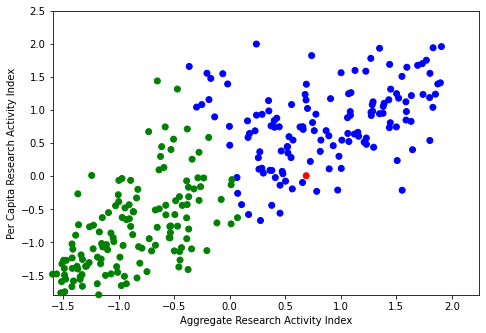

In [19]:
print('hello')
scaler = StandardScaler()
std_agg =  scaler.fit_transform(data2021['agg_index'].values.reshape(-1,1))
std_cap =  scaler.fit_transform(data2021['per_cap_index'].values.reshape(-1,1))

min_x = min(std_agg)
min_y =  min(std_cap)

split = np.median(data2021['stand_distance'])
colors =['green' if d <= split else 'blue' for d in data2021['stand_distance']]

unt = list(data2021.index).index('University of North Texas')

colors[unt] = 'red'

fig, ax = plt.subplots(figsize=(7.65,5.22))
ax.scatter(std_agg, std_cap,c=colors, zorder=5, clip_on=False)

ax.set_xlim((min_x,2.25))
ax.set_ylim((min_y,2.5))

ax.set_xlabel('Aggregate Research Activity Index')
ax.set_ylabel('Per Capita Research Activity Index')
plt.show()

### Wrap this all up into a Rank python class 

In [24]:
class Rank():

    def __init__(self, data_dir, data_file):
        columns = ['name', 'include','serd','nonserd','pdnfrstaff','facnum','socsc_rsd','hum_rsd','stem_rsd','oth_rsd']

        self.data = pd.read_excel(DATA+'\\CCIHE2021-PublicData_02022022.xlsx',
                                  sheet_name='Data',
                                  engine='openpyxl',
                                  usecols=columns,
                                  index_col='name')

        self.data  = self.data[self.data['include'] == 1]
        self.data .fillna(value=0, inplace=True)
        # data2018.shape

        self.data = self.apply_activity_index(self.data)

    def apply_activity_index(self, data):
        per_cap_serd = data['serd']/data['facnum']
        per_cap_non_serd = data['nonserd']/data['facnum']
        per_cap_staff = data['pdnfrstaff']/data['facnum']
        
        per_cap_serd_rank     = per_cap_serd.rank()
        per_cap_non_serd_rank = per_cap_non_serd.rank()
        per_cap_staff_rank    = per_cap_staff.rank()

        serd_rank      = data['serd'].rank()
        non_serd_rank  = data['nonserd'].rank()
        staff_rank     = data['pdnfrstaff'].rank()
        hum_rsd_rank   = data['hum_rsd'].rank()
        sosc_rsd_rank  = data['socsc_rsd'].rank()
        stem_rsd_rank  = data['stem_rsd'].rank()
        other_rsd_rank = data['oth_rsd'].rank()
            
        RankDF_cap  = pd.DataFrame({
                            'per_cap_serd'     : per_cap_serd_rank, 
                            'per_cap_non_serd' : per_cap_non_serd_rank,
                            'per_cap_staff'    : per_cap_staff_rank})
        RankDF_agg = pd.DataFrame({
                            'serd'             : serd_rank,
                            'non_serd'         : non_serd_rank,
                            'staff'            : staff_rank,
                            'hum_rsd'          : hum_rsd_rank,
                            'sosc_rsd'         : sosc_rsd_rank,
                            'stem_rsd'         : stem_rsd_rank,
                            'other_rsd'        : other_rsd_rank})

 
        scaler = StandardScaler()
        X = scaler.fit_transform(RankDF_cap)
        pca = PCA( n_components=0.7, svd_solver='full')
        pca.fit(X)
        loadings_cap = pca.components_.T * np.sqrt(pca.explained_variance_)
        loadings_matrix_cap = pd.DataFrame(loadings_cap, columns=['PC1'], index=RankDF_cap.columns)

                
        X = scaler.fit_transform(RankDF_agg)
        pca = PCA(n_components=0.7, svd_solver = 'full')
        pca.fit(X)
        loadings_agg = pca.components_.T * np.sqrt(pca.explained_variance_)
        loadings_matrix_agg = pd.DataFrame(loadings_agg, columns=['PC1'], index=RankDF_agg.columns)

        agg_index = pd.Series(data= [0]*len(RankDF_agg), name='agg index', index=RankDF_agg.index)
        for col in RankDF_agg.columns:
            loading =  loadings_matrix_agg.loc[col].values[0]
            weighted = RankDF_agg[col] * loading
            agg_index += weighted

        # display(agg_index.head())

        per_cap_index = pd.Series(data= [0]*len(RankDF_cap), name='per-capita index', index=RankDF_cap.index)
        for col in RankDF_cap.columns:
            loading =  loadings_matrix_cap.loc[col].values[0]
            weighted = RankDF_cap[col] * loading
            per_cap_index += weighted

        # display(per_cap_index.head())

        agg_index = agg_index - min(agg_index)
        data['agg_index'] = agg_index
        per_cap_index = per_cap_index - min(per_cap_index)
        data['per_cap_index'] = per_cap_index

        raw_distance = np.sqrt(agg_index**2 + per_cap_index**2)
        data['raw_distance'] = raw_distance

        
        stand_distance = (raw_distance - np.mean(raw_distance))/np.std(raw_distance)
        data['stand_distance'] = stand_distance

        ranking = stand_distance.rank(ascending=False)
        data['ranking'] = ranking

        return data

    def re_rank(self,name, **kwargs):
        """input institution name and change in one or more measueres in {'serd', 'nonserd', 
           'pdnfrstaff', 'facnum', 'hum_rsd', 'socsc_rsd', 'stem_rsd', 'other_rsd'}"""

        data = self.data.copy()
        print(name)
        for key, value in kwargs.items():
            if key in ['serd', 'nonserd','pdnfrstaff', 'facnum', 'hum_rsd', 'socsc_rsd', 'stem_rsd', 'other_rsd']:
                print('modifying' ,key , 'value')
                data.loc[name][key] = value
            else:
                raise ValueError('not a valid measure')

        return self.apply_activity_index(data)

    
    def plot_rank(self, data=None):
        if not data:
            data = self.data

        std_agg =  scaler.fit_transform(data['agg_index'].values.reshape(-1,1))
        std_cap =  scaler.fit_transform(data['per_cap_index'].values.reshape(-1,1))

        min_x = min(std_agg)
        min_y =  min(std_cap)
        
        split = np.median(data['stand_distance'])
        colors =['green' if d <= split else 'blue' for d in data['stand_distance']]

        unt = list(data.index).index('University of North Texas')

        colors[unt] = 'red'

        fig, ax = plt.subplots(figsize=(7.65,5.22))
        ax.scatter(std_agg, std_cap,c=colors, zorder=5, clip_on=False)

        ax.set_xlim((min_x,2.25))
        ax.set_ylim((min_y,2.5))

        ax.set_xlabel('Aggregate Research Activity Index')
        ax.set_ylabel('Per Capita Research Activity Index')

        return fig
        

## test class

In [25]:
rank = Rank(DATA, data_file ='CCIHE2021-PublicDataFile_02022022.xlsx')

C:\Users\crm0376\AppData\Local\Temp/ipykernel_33000/1577837839.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


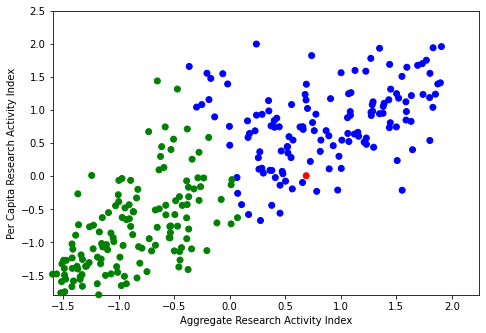

In [26]:
fig = rank.plot_rank()
fig.show()

In [22]:
display(rank.data.sort_values(by='ranking')[['ranking']])

,ranking
name,
Harvard University,1.0
University of Pennsylvania,2.0
University of Wisconsin-Madison,3.0
University of Michigan-Ann Arbor,4.0
University of California-Berkeley,5.0
...,...
Loyola Marymount University,263.0
Arkansas State University,264.0
Southern University and A & M College,265.0
